<a href="https://colab.research.google.com/github/Paradorn657/recurrent_nearal/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence - vector RNN**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
   # รับ series มา จัดกลุ่ม 30 และ 31 คือ ลาเบล ในทุกๆสโคบ
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

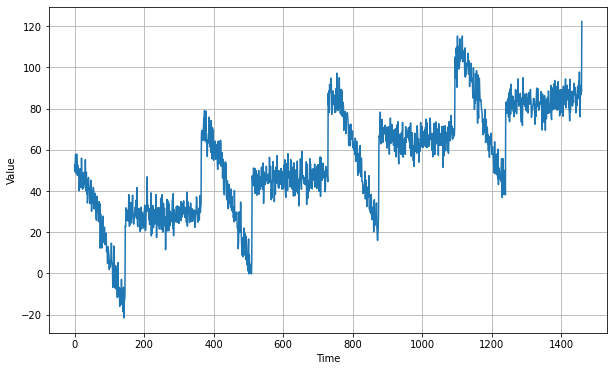

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]

time_valid = time[split_time:]
series_valid = series[split_time:]

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series_train, window_size, batch_size=128)
valid_set = window_dataset(series_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]), # train_set มันมี 2 มิติ ต้องเข้า lamda แปลงเป็น 3 เข้า RNN -- input_shape=[None] คือ รับ any length
  keras.layers.SimpleRNN(100, return_sequences=True),# ออกเป็น sequence (ตามลำดับ)
  keras.layers.SimpleRNN(100),# ออกเป็น vector
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # ตัวเลขมันน้อยเลยต้องคูณ เพื่อให้คำนวณง่ายๆ
])
model.compile(loss=keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 85ms/step - loss: 103.2320 - mae: 108.0750 - val_loss: 38.8899 - val_mae: 39.3284
Epoch 2/500
8/8 [==============================] - 0s 47ms/step - loss: 49.9623 - mae: 51.1376 - val_loss: 11.9684 - val_mae: 12.6767
Epoch 3/500
8/8 [==============================] - 0s 55ms/step - loss: 25.0628 - mae: 26.1031 - val_loss: 6.7043 - val_mae: 7.1407
Epoch 4/500
8/8 [==============================] - 0s 44ms/step - loss: 14.5322 - mae: 15.0352 - val_loss: 6.0986 - val_mae: 6.4764
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 8.2440 - mae: 8.8329 - val_loss: 6.0481 - val_mae: 6.5593
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 6.1558 - mae: 6.5731 - val_loss: 5.0442 - val_mae: 5.5091
Epoch 7/500
8/8 [==============================] - 0s 48ms/step - loss: 5.7332 - mae: 6.1910 - val_loss: 5.0499 - val_mae: 5.6781
Epoch 8/500
8/8 [==============================] - 0s 48ms/step - loss: 6.40

In [0]:
  def model_forecast(model, series, window_size):
  # รับ series มา จัดกลุ่ม 30 แล้ว predict
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
  

In [0]:
rnn_forecast = model_forecast(model,series[split_time - window_size:-1],window_size)[:, 0]

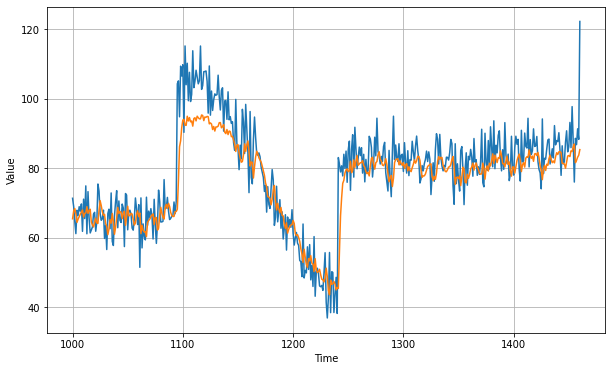

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()

5.5599847

# **Sequence - Sequence RNN**

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series_train, window_size,batch_size=128)
valid_set = window_dataset(series_valid, window_size,batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),                               
  keras.layers.SimpleRNN(100, return_sequences=True,input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
model.compile(loss=keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 71ms/step - loss: 99.2119 - mae: 104.0274 - val_loss: 40.0583 - val_mae: 40.5247
Epoch 2/500
8/8 [==============================] - 0s 52ms/step - loss: 48.6059 - mae: 50.3208 - val_loss: 10.9119 - val_mae: 11.3065
Epoch 3/500
8/8 [==============================] - 0s 50ms/step - loss: 24.5782 - mae: 25.7689 - val_loss: 9.8950 - val_mae: 10.2892
Epoch 4/500
8/8 [==============================] - 0s 55ms/step - loss: 17.2218 - mae: 17.7098 - val_loss: 9.4345 - val_mae: 9.7472
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 12.2300 - mae: 12.7151 - val_loss: 13.9649 - val_mae: 14.3597
Epoch 6/500
8/8 [==============================] - 0s 46ms/step - loss: 9.9448 - mae: 10.4652 - val_loss: 14.1361 - val_mae: 13.9946
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 9.4715 - mae: 9.9917 - val_loss: 13.6356 - val_mae: 14.4952
Epoch 8/500
8/8 [==============================] - 0s 51ms/step - l

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

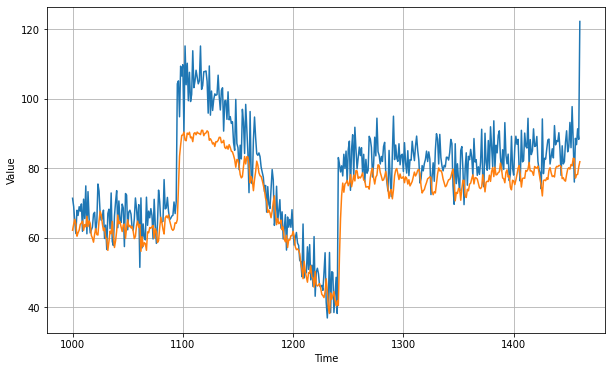

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()

7.442959